Feature: Graphical Models
=========================

NOTE: Graphical models are an in-development feature. This example serves to illustrate what we currently developing ,
but the API is subject to change and many core features (all searches, database tools, etc.) are not
fully supported. If you are interested in using graphical models I recommend you contact me directly
(https://github.com/Jammy2211) so we can discuss when **PyAutoFit** will be ready for your use-case.

The examples so far have focused on fitting one model to one dataset, for example fitting 1D profiles composed of
Gaussians to noisy 1D data. When multiple datasets were available each was fitted individually and their results
interpreted one-by-one using the `Result` object or **PyAutoFit**'s database tools.

However, for many problems we may have a large dataset and not be interested in how well the model fits each dataset
individually. Instead, we may wish to fit this model (or many similar models) to the full dataset and determine
the 'global' trends of the model across the datasets.

This can be done using graphical models, which compose and fit a model that has 'local' parameters specific to each
individual dataset but also higher-level model components that fit 'global' parameters of the model across the whole
dataset. This framework can be easily extended to fit datasets with different properties, models with different
topologies and has the functionality to allow it to be generalized to models with thousands of parameters.

In this example, we demonstrate the basic API for performing graphical modeling in **PyAutoFit** using the example of
fitting noisy 1D Gaussians. However, graphical models are an extensive feature and at the end of this example we will
discuss the many options available in **PyAutoFit** for composing a fitting a graphical model. The **HowToFit**
tutorials contain a chapter dedicated to composing and complex graphical models.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autofit as af
from os import path
import matplotlib.pyplot as plt

/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace`


We are going to build a graphical model that fits three datasets. 

NOTE: In this example we explicitly write code for loading each dataset and store each dataset as their own Python
variable (e.g. data_0, data_1, data_2, etc.). We do not use a for loop or a list to do this, even though this would 
be syntactically cleaner code. This is to make the API for setting up a graphical model in this example clear and 
explicit; in the **HowToFit** tutorials we we introduce the **PyAutoFit** API for setting up a graphical model for 
large datasets concisely.

In [2]:
dataset_path = path.join("dataset", "example_1d")

dataset_0_path = path.join(dataset_path, "gaussian_x1_0__low_snr")
data_0 = af.util.numpy_array_from_json(file_path=path.join(dataset_0_path, "data.json"))
noise_map_0 = af.util.numpy_array_from_json(
    file_path=path.join(dataset_0_path, "noise_map.json")
)

dataset_1_path = path.join(dataset_path, "gaussian_x1_1__low_snr")
data_1 = af.util.numpy_array_from_json(file_path=path.join(dataset_1_path, "data.json"))
noise_map_1 = af.util.numpy_array_from_json(
    file_path=path.join(dataset_1_path, "noise_map.json")
)

dataset_2_path = path.join(dataset_path, "gaussian_x1_2__low_snr")
data_2 = af.util.numpy_array_from_json(file_path=path.join(dataset_2_path, "data.json"))
noise_map_2 = af.util.numpy_array_from_json(
    file_path=path.join(dataset_2_path, "noise_map.json")
)

Now lets plot the data, including their error bars. One should note that we are fitting much lower signal-to-noise
datasets than usual.

Note that all three of these `Gaussian`'s were simulated using the same `centre` value. To demonstrate graphical 
modeling we will therefore fit a model where the `centre` a shared parameter across the fit to the 3 `Gaussian`s, 
therefore making it a global parameter.

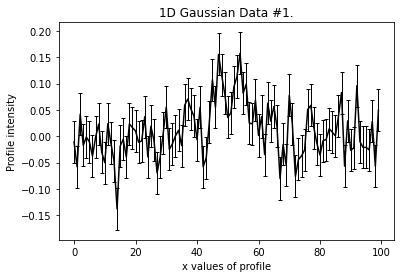

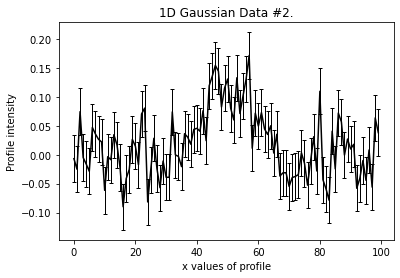

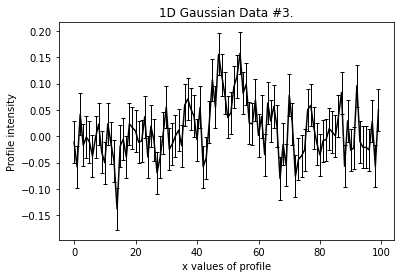

In [3]:
xvalues = range(data_0.shape[0])

plt.errorbar(
    x=xvalues,
    y=data_0,
    yerr=noise_map_0,
    color="k",
    ecolor="k",
    elinewidth=1,
    capsize=2,
)
plt.title("1D Gaussian Data #1.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

xvalues = range(data_1.shape[0])

plt.errorbar(
    x=xvalues,
    y=data_1,
    yerr=noise_map_1,
    color="k",
    ecolor="k",
    elinewidth=1,
    capsize=2,
)
plt.title("1D Gaussian Data #2.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

xvalues = range(data_0.shape[0])

plt.errorbar(
    x=xvalues,
    y=data_0,
    yerr=noise_map_0,
    color="k",
    ecolor="k",
    elinewidth=1,
    capsize=2,
)
plt.title("1D Gaussian Data #3.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

For each dataset we now create a corresponding `Analysis` class (we use the `Analysis` class from `complex/fit`).

By associating each dataset with an `Analysis` class we are therefore associating it with a unique 
`log_likelihood_function`. Because every dataset has its own `Analysis` class, it is straight forward to build a 
graphical model where datasets with different structures or formats are fitted. This is demonstrated in the graphical
models chapter of **HowToFit**.

In [4]:
import analysis as a

analysis_0 = a.Analysis(data=data_0, noise_map=noise_map_0)
analysis_1 = a.Analysis(data=data_1, noise_map=noise_map_1)
analysis_2 = a.Analysis(data=data_2, noise_map=noise_map_2)

We now compose the graphical model we will fit using the `PriorModel` and `CollectionPriorModel` objects described in 
the `overview` examples and chapter 1 of **HowToFit**.

In [5]:
from autofit import graphical as g
import model as m

We begin by setting up a shared prior for `centre`, which is set up this up as a single `GaussianPrior` that is 
passed to a unique `PriorModel` for each `Gaussian`. This means all three `Gaussian`'s will be fitted wih the same 
value of `centre`.

In [6]:
centre_shared_prior = af.GaussianPrior(mean=50.0, sigma=30.0)

We now set up three `CollectionPriorModel`'s, each of which contain a `Gaussian` that is used to fit each of the 
datasets we loaded above.

All three of these `CollectionPriorModel`'s use the `centre_shared_prior`. This means all three `Gaussian` 
model-components use the same value of `centre` when model-fitting is performed reducing the dimensionality of
parameter space from N=9 (e.g. 3 parameters per Gaussian) to N=7.

Our graphical model therefore consists of three `Gaussians` with local parameters (a unique `intensity` and `sigma`)
for each `Gaussian` and a global parameter for the graphical model (the `centre` of all three `Gaussians`).

In [7]:
gaussian_0 = af.PriorModel(m.Gaussian)
gaussian_0.centre = centre_shared_prior
gaussian_0.intensity = af.GaussianPrior(mean=10.0, sigma=10.0)
gaussian_0.sigma = af.GaussianPrior(
    mean=10.0, sigma=10.0
)  # This prior is used by all 3 Gaussians!

prior_model_0 = af.CollectionPriorModel(gaussian=gaussian_0)

gaussian_1 = af.PriorModel(m.Gaussian)
gaussian_1.centre = centre_shared_prior
gaussian_1.intensity = af.GaussianPrior(mean=10.0, sigma=10.0)
gaussian_1.sigma = af.GaussianPrior(
    mean=10.0, sigma=10.0
)  # This prior is used by all 3 Gaussians!

prior_model_1 = af.CollectionPriorModel(gaussian=gaussian_1)

gaussian_2 = af.PriorModel(m.Gaussian)
gaussian_2.centre = centre_shared_prior
gaussian_2.intensity = af.GaussianPrior(mean=10.0, sigma=10.0)
gaussian_2.sigma = af.GaussianPrior(
    mean=10.0, sigma=10.0
)  # This prior is used by all 3 Gaussians!

prior_model_2 = af.CollectionPriorModel(gaussian=gaussian_2)

Above, we composed a model consisting of three `Gaussian`'s with a shared `centre` prior. We also loaded three 
datasets which we intend to fit with each of these `Gaussians`, setting up each in an `Analysis` class that defines 
how the model is used to fit the data.

We now simply need to pair each model-component to each `Analysis` class, so that **PyAutoFit** knows that: 

- `prior_model_0` fits `data_0` via `analysis_0`.
- `prior_model_1` fits `data_1` via `analysis_1`.
- `prior_model_2` fits `data_2` via `analysis_2`.

The point where a `PriorModel` and `Analysis` class meet is called a `ModelFactor`. 

This term is used to denote that we are composing a graphical model, which is commonly termed a 'factor graph'. A 
factor defines a node on this graph where we have some data, a model, and we fit the two together. The 'links' between 
these different nodes then define the global model we are fitting.

In [8]:
model_factor_0 = g.ModelFactor(prior_model=prior_model_0, analysis=analysis_0)
model_factor_1 = g.ModelFactor(prior_model=prior_model_1, analysis=analysis_1)
model_factor_2 = g.ModelFactor(prior_model=prior_model_2, analysis=analysis_2)

We combine our `ModelFactors` into one, to compose the factor graph.

In [9]:
factor_graph = g.FactorGraphModel(model_factor_0, model_factor_1, model_factor_2)

So, what is a factor graph?

A factor graph defines the graphical model we have composed. For example, it defines the different model components 
that make up our model (e.g. the three `Gaussian` classes) and how their parameters are linked or shared (e.g. that
each `Gaussian` has its own unique `intensity` and `sigma`, but a shared `centre` parameter.

This is what our factor graph looks like: 

The factor graph above is made up of two components:

- Nodes: these are points on the graph where we have a unique set of data and a model that is made up of a subset of 
our overall graphical model. This is effectively the `ModelFactor` objects we created above. 

- Links: these define the model components and parameters that are shared across different nodes and thus retain the 
same values when fitting different datasets.

In [10]:
from autofit.graphical import optimise

laplace = optimise.LaplaceFactorOptimiser()
collection = factor_graph.optimise(laplace)

print(collection)

/mnt/c/Users/Jammy/Code/PyAuto/PyAutoFit/autofit/graphical/messages/normal.py:63: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(- 0.5 / eta2)


Gaussian (centre, GaussianPrior, mean = 50.815703795965426, sigma = 0.658242582008975), (intensity, GaussianPrior, mean = 1.4691843534126745, sigma = 0.22648381096679931), (sigma, GaussianPrior, mean = 5.9619862357023115, sigma = 1.1517164804549278), Gaussian (centre, GaussianPrior, mean = 50.815703795965426, sigma = 0.658242582008975), (intensity, GaussianPrior, mean = 2.2896259705440904, sigma = 0.23469067414188646), (sigma, GaussianPrior, mean = 7.392541950599671, sigma = 0.7421258737010711), Gaussian (centre, GaussianPrior, mean = 50.815703795965426, sigma = 0.658242582008975), (intensity, GaussianPrior, mean = 4.655074505398767, sigma = 0.3468248474420943), (sigma, GaussianPrior, mean = 13.729783273809957, sigma = 1.2163685583849255)


__Road Map__

The example above illustrates a simple graphical model where 3 datasets are fitted. Each fit has two local parameters
and one global parameter. 

Graphical models are an in development feature and the following functionality is currently in development:

 - Searches: Currently a graphical model must be fitted using the `LaplaceOptimiser` class. They therefore do not 
 support `NonLinearSearch`'s like `Emcee` and `Dynesty` nor do they support results output, visualization or database
 outputs. Graphical models will soon fully support all `NonLinearSearch`'s objects and therefore also outputs, 
 visualization and database features.
 
 - Message passing: The graphical model above fitted all 7 parameters simultaneously. If the dataset was large the
 number of parameters would increase drastically, making it inefficient or impossible to fit the model (for example,
 with 1000 `Gaussian`'s our model would have had 2001 parameters!). Graphical models in **PyAutoFit** support the
 message passing framework below, which allows one to fit the local model to every dataset individually and pass 
 messages 'up and down' the graph to infer the global parameters efficiently.
 
 https://arxiv.org/pdf/1412.4869.pdf

 - More advanced models: The model above fitted a single global parameter which was shared across the dataset. The
 framework will allow one to fit for the distributions from which parameters are draw or for trends between parameters.
 The graphical model framework itself can already do this, we simply need to write the **HowToFit** tutorials that will
 demonstrate how!